In [1]:
import numpy as np
import cte
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib.gridspec as gridspec
from scipy.interpolate import interp1d
from ProcessFunctions import Find_T_X_tau_without_p_input,FindStarts_ends
from matplotlib.patches import Rectangle 


# To do:
* Find the event timing for QDYN, model N_m=20, and model N_m=30. As a check point, time of the event should give you zero for the PDE. (done)
* The next step is to plot the rectangles for all of the plots (done)
* The next step is to write a piece of code that record TimeStarts and rectangles (done)
* find the true positive rupture extent (done)
* find the false positive probability (done)
* plot the histogram and pdfs (done)
* make the code robust to when there is no event in the data, conditions like having no events or multiple events in the prediction, I think if there are multiple events, to study the quality of prediction, you should aggregate all of them (done).
* try to make it work for all of the numbers (done)
* write what you have done: remember to write that in the forecast If multiple partial ruptures are predicted predicted rupture extent is considered to be the sum of all of them.
* conclusion is that I need to work on model with n=60 to improve the results. The model wih n=40 works well.

This code is written to plot the prediction using the PDE as governing equation and estimated initial condition using data assimilation with ROM.
To generate data for this code, you need to run `Fig_Stress_Vel_inversion.ipynb`


In [2]:
Tf = 250 # each initial condition is simulated for 250 years
Nt=5     # it is recorded every Nt time stes
N_m_load=30
coeff=2 # How the inital conditions are from the chaotic attractor
Obs_linear=0
N_t=4000
m=80
sigma_kernel=2000
gamma_ratio=0.0001*5
version=2024.11
Mag_thresh=6.9
tau=0.1
L=cte.L_asp+cte.L_buffer  
Nx=256
T_final=10*tau*cte.t_yr # plotting 30 tau of simulation
V_thresh=(5e-8) # to define an event
L_thresh=1e3 # to define an event
t_yr=cte.t_yr
size_x=256
size_y=32
W=cte.W  
x_ox=np.linspace(-L/2,L/2,size_x)
z_ox=np.linspace(0,W,size_y)
L_fault=L
mu=30e9
t_pred=0.4

In [3]:
# for different inversions (denoted by number) and differnet ROM (denoted by N_m_v), we need to load the corresponding data
N_m_v_list = [20,30]
#numbers = [101,102]
numbers = [101,102,103,104,105,106,107,108,109,110]
# numbers=[110]
data_PDE = []
data_prediction_20 = []
data_prediction_30 = []
data_inversion_20 = []
data_inversion_30 = []
for i in range(len(numbers)):
    number=numbers[i]
    data_dir="/central/groups/astuart/hkaveh/Data/LearnROM/Dataset2/SampleSimulation_Tf"+str(Tf)+"Nt="+str(Nt)+"N_m"+str(N_m_load)+"coeff"+str(coeff)+"number"+str(number)+".npz"
    data=np.load(data_dir)
    data_PDE.append(data)
    for j in range(len(N_m_v_list)):

        N_m_v=N_m_v_list[j]
        N_m_theta=N_m_v
        data_dir_pred="/central/groups/astuart/hkaveh/Data/LearnROM/PredictionN_m_v"+str(N_m_v)+"N_m_theta"+str(N_m_theta)+"Obs_linear"+str(Obs_linear)+"N_t"+str(N_t)+"m"+str(m)+"sigma_kernel"+str(sigma_kernel)+"gamma_ratio"+str(gamma_ratio)+"version"+str(version)+"NumberinDataset"+str(number)+"tau"+str(tau)+"Mag_thresh"+str(Mag_thresh)+".npz"
        data=np.load(data_dir_pred,allow_pickle=True)
        if N_m_v==20:
            data_inversion=np.load("/central/groups/astuart/hkaveh/Data/LearnROM/EnKF_N_m_v"+str(N_m_v)+"N_m_theta"+str(N_m_theta)+"Obs_linear"+str(Obs_linear)+"N_t"+str(N_t)+"m"+str(m)+"sigma_kernel"+str(sigma_kernel)+"gamma_ratio"+str(gamma_ratio)+"version"+str(version)+"NumberinDataset"+str(number)+'.npz')
            data_inversion_20.append(data_inversion)
            data_prediction_20.append(data)
        elif N_m_v==30:
            data_inversion=np.load("/central/groups/astuart/hkaveh/Data/LearnROM/EnKF_N_m_v"+str(N_m_v)+"N_m_theta"+str(N_m_theta)+"Obs_linear"+str(Obs_linear)+"N_t"+str(N_t)+"m"+str(m)+"sigma_kernel"+str(sigma_kernel)+"gamma_ratio"+str(gamma_ratio)+"version"+str(version)+"NumberinDataset"+str(number)+'.npz')
            data_inversion_30.append(data_inversion)
            data_prediction_30.append(data)
    

In [4]:
# The inversion data is saved like : np.savez('/central/groups/astuart/hkaveh/Data/LearnROM/Prediction'+"N_m_v"+str(N_m_v)+"N_m_theta"+str(N_m_theta)+"Obs_linear"+str(Obs_linear)+"N_t"+str(N_t)+"m"+str(m)+"sigma_kernel"+str(sigma_kernel)+"gamma_ratio"+str(gamma_ratio)+"version"+str(version)+"NumberinDataset"+str(number)+"tau"+str(tau)+"Mag_thresh"+str(Mag_thresh)+".npz",V_ox_pred_events=V_ox_pred_events,t_ox_pred_events=t_ox_pred_events,TimeStarts_preds_events=TimeStarts_preds_events,Mags_preds_events=Mags_preds_events,index_events=index_events,TimeStarts_filtered=TimeStarts_filtered,TimeEnds_filtered=TimeEnds_filtered,rectangles_filtered=rectangles_filtered,Mags_filtered=Mags_filtered)


In [5]:
# finding total number of events=nroww: pick one N_m_v. for all of the inversions sum the number of elements in Mags_filtered
# writing this in one line
nrows=sum([data_prediction_20[i]['Mags_filtered'].shape[0] for i in range(len(data_prediction_20))])

In [6]:
letters=['a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y','z']

In [7]:
def interpolate(time_interpolation,original_time,original_data,size_y,size_x):
    output=np.zeros((len(time_interpolation),size_y,size_x))
    for i in range(size_y):
        for j in range(size_x):
            f = interp1d(original_time[:,i,j], original_data[:,i,j], kind='linear')
            output[:,i,j]=f(time_interpolation)
    return output

In [8]:
# making a nice plot for the paper

# I am thinking of of 3 collomn figure with the first coloumn to be the QDYN simulation, the second one with N_m=20 and the third one to be N_m=30. 
# This should be a good idea that you can also see the difference in the forecast as well.
# this block is plotted without interpolation so you can see some white shades. 
# In the next block I interpolate things, so there is no white shade.
# To make this plot, I think it is better that you have already saved everything in the variables.
V_thresh_min=1e-9
V_thresh_max=1e-6  
x_ox=np.linspace(-L/2,L/2,Nx) 
# 1- define the figure size and the font size
fig = plt.figure(figsize=(7.4, nrows*3.7))
serif_font = fm.FontProperties(family="serif", size=8)
cmap='jet'
    # Use serif font and set font size for all text in the figure
plt.rc('font', family='serif')
plt.rcParams.update({'font.family': 'serif'})
plt.rcParams.update({'font.size': 8})
height_ratios=([1]*nrows)
height_ratios.append(0.1)
gs = gridspec.GridSpec(nrows=nrows+1, ncols=3,width_ratios=[1,1,1],height_ratios=height_ratios) # I put 2 columns for now to wait to see how does the system look like for N_m=30
index_row_plot=0
cax=fig.add_subplot(gs[-1, :])  
shift_string=10
for index in range(len(numbers)):
#for index in range(1): # for example when index=0 number =101
    time_start_events_PDE=data_prediction_20[index]['TimeStarts_filtered']
    t_0_inversion=data_inversion_20[index]['t_0']
    V_ox_pred_events_20=data_prediction_20[index]["V_ox_pred_events"]
    V_ox_pred_events_30=data_prediction_30[index]["V_ox_pred_events"]
    t_ox_pred_events_20=data_prediction_20[index]["t_ox_pred_events"]
    t_ox_pred_events_30=data_prediction_30[index]["t_ox_pred_events"]
    # run the code to plot things
    for event_counter in range(data_prediction_20[index]['Mags_filtered'].shape[0]): # number of events in the indexth number
        ax_qdyn= fig.add_subplot(gs[index_row_plot, 0]) # True slip rate
        ax_Nm20= fig.add_subplot(gs[index_row_plot, 1]) # Observed slip rate
        ax_Nm30= fig.add_subplot(gs[index_row_plot, 2]) # Observed slip rate
        string_qdyn='('+letters[index_row_plot]+'1)'
        string_20='('+letters[index_row_plot]+'2)'
        string_30='('+letters[index_row_plot]+'3)'
        # cax1 = fig.add_subplot(gs[index_row_plot, 1])  
        # cax2 = fig.add_subplot(gs[index_row_plot, 3]) 
        # cax3 = fig.add_subplot(gs[index_row_plot, 5])
        # loading data in data_PDE[index]
        V_ox=data_PDE[index]['array1']
        theta_ox=data_PDE[index]['array2']
        t_ox=data_PDE[index]['array3']
        # loading time of the start of the events: TimeStarts_filtered, this number should be added to start time which is the time that inversion starts


        # Plotting the QDYN acutual slip profile for the events
        V_dip_mean=np.max(V_ox,axis=1).T   # Mean Velocity along the dip
        Nt=t_ox.shape[0]
        x_ox_t=np.vstack([x_ox]*Nt).T 
        time=np.max(t_ox,axis=1).T 
        PrettyTime=np.reshape(time.T,-1)
        Prettyx=np.reshape(x_ox_t.T,-1)
        PrettyV=np.reshape(V_dip_mean.T,-1)
        xlimleft=((time_start_events_PDE[event_counter]+t_0_inversion)/cte.t_yr)
        xlimright=((time_start_events_PDE[event_counter]+t_0_inversion)/cte.t_yr)+(T_final/cte.t_yr)
        
        pl=ax_qdyn.scatter(PrettyTime/cte.t_yr-xlimleft,Prettyx*1e-3,marker=".",c=np.log10(PrettyV),cmap=cmap,linewidths=1,vmin=np.log10(V_thresh_min),vmax=np.log10(V_thresh_max))  
        ax_qdyn.set_ylabel(r'Distance along strike (km)',fontproperties=serif_font)

        ax_qdyn.set_xlim(left=-tau,right=-tau+(T_final/cte.t_yr))
        # b=fig.colorbar(pl,cax=cax1)
        # b.set_label(label=r'$log_{10}(V(m/s))$',fontproperties=serif_font)
        ax_qdyn.set_ylim(bottom=-L/2/1e3,top=L/2/1e3)
        index_row_plot+=1
        ax_qdyn.text(-tau,L/2/1000+shift_string,string_qdyn)

        # plotting N_m_v=20
        V_dip_mean=np.max(V_ox_pred_events_20[event_counter],axis=1).T   # Mean Velocity along the dip
        Nt=t_ox_pred_events_20[event_counter].shape[0]
        x_ox_t=np.vstack([x_ox]*Nt).T 
        x_ox_t=np.vstack([x_ox]*Nt).T 
        time=np.max(t_ox_pred_events_20[event_counter],axis=1).T # what? simply getting rid of the axis 1 because axis 0 and 1 have the same value for time
        
        PrettyTime=np.reshape(time.T,-1)
        Prettyx=np.reshape(x_ox_t.T,-1)
        PrettyV=np.reshape(V_dip_mean.T,-1)
        pl=ax_Nm20.scatter(PrettyTime/cte.t_yr-tau,Prettyx*1e-3,marker=".",c=np.log10(PrettyV),cmap=cmap,linewidths=1,vmin=np.log10(V_thresh_min),vmax=np.log10(V_thresh_max))
        ax_Nm20.set_xlim(left=-tau,right=-tau+T_final/cte.t_yr)

        # ax_Nm20.set_xlabel(r'Time (year)',fontproperties=serif_font)
        # ax_Nm20.set_ylabel(r'Distance along strike (km)',fontproperties=serif_font)
        # b=fig.colorbar(pl,cax=cax2)
        # b.set_label(label=r'$log_{10}(V(m/s))$',fontproperties=serif_font)
        ax_Nm20.set_ylim(bottom=-L/2/1e3,top=L/2/1e3)
        ax_Nm20.text(-tau,L/2/1000+shift_string,string_20)

        # plotting N_m_v=30
        V_dip_mean=np.max(V_ox_pred_events_30[event_counter],axis=1).T   # Mean Velocity along the dip
        Nt=t_ox_pred_events_30[event_counter].shape[0]
        x_ox_t=np.vstack([x_ox]*Nt).T
        time=np.max(t_ox_pred_events_30[event_counter],axis=1).T 
        PrettyTime=np.reshape(time.T,-1)
        Prettyx=np.reshape(x_ox_t.T,-1)
        PrettyV=np.reshape(V_dip_mean.T,-1)
        pl=ax_Nm30.scatter(PrettyTime/cte.t_yr-tau,Prettyx*1e-3,marker=".",c=np.log10(PrettyV),cmap=cmap,linewidths=1,vmin=np.log10(V_thresh_min),vmax=np.log10(V_thresh_max))
        ax_Nm30.set_xlim(left=-tau,right=-tau+T_final/cte.t_yr)
        # ax_Nm30.set_xlabel(r'Time (year)',fontproperties=serif_font)
        # ax_Nm30.set_ylabel(r'Distance along strike (km)',fontproperties=serif_font)
        # b=fig.colorbar(pl,cax=cax3)
        # b.set_label(label=r'$log_{10}(V(m/s))$',fontproperties=serif_font)
        ax_Nm30.set_ylim(bottom=-L/2/1e3,top=L/2/1e3)
        ax_Nm30.text(-tau,L/2/1000+shift_string,string_30)
        # removing y ticks and y numbers 
        #ax_qdyn.set_yticks([])
        ax_Nm20.set_yticks([])
        ax_Nm30.set_yticks([])
        
    
    # putting the xlable outside both of the loops to only print the lable for the last row
ax_qdyn.set_xlabel(r'Time (year)',fontproperties=serif_font)
ax_Nm20.set_xlabel(r'Time (year)',fontproperties=serif_font)
ax_Nm30.set_xlabel(r'Time (year)',fontproperties=serif_font)
b=fig.colorbar(pl,cax=cax,orientation='horizontal')
b.set_label(label=r'$log_{10}(V(m/s))$',fontproperties=serif_font)

    
    
plt.show()


In [ ]:
N_time=int(T_final/(2*3600))
time_interpolation=np.linspace(0,T_final,N_time)


In [ ]:
1*365*24*3600/4000

7884.0

In [ ]:
# Expand the dimensions of 'a' to make it (1000, 1, 1)
t_expanded = time_interpolation[:, np.newaxis, np.newaxis]

# Use np.tile to copy the values along the other dimensions
t_expanded = np.tile(t_expanded, (1, 32, 256))


In [ ]:
def PlotRectangle(axes,rectangles):
    # This is a function to plot rectangles for to show the event start and end and the rupture extent
    Nrectangles=int(rectangles.size/4)
    rectangles=np.reshape(rectangles,(Nrectangles,4))
        
    for i in range(Nrectangles):
        axes.add_patch( Rectangle((rectangles[i,0], rectangles[i,1]), rectangles[i,2], rectangles[i,3], fc ='none',  ec ='w', lw = 3) ) 
    return axes
        

In [ ]:
def add_array(events,event_name, rectangles):
    # this function is written to add the rectangles to the dictionary
    if event_name not in events:
        events[event_name] = []  # Create a new list for the event
    
    Nrectangles=int(rectangles.size/4) # counding number of rectangles
    rectangles=np.reshape(rectangles,(Nrectangles,4))
    for index in range(Nrectangles):
        events[event_name].append(rectangles[index,:].reshape(4, 1))  # Append the array to the event's list
        print(rectangles[index,:].reshape(4, 1))
    return events

In [ ]:
Time_lag20=[] # recording the time lags here for N_m=20
Time_lag30=[] # recording the time lags here for N_m=30
# All_rectangles_PDE= np.empty((4, 1)) 
# All_rectangles_20= np.empty((4, 1)) 
# All_rectangles_30= np.empty((4, 1)) 
events_PDE= {}
events_20 ={}
events_30 ={}



(4382, 256)
(4382, 256)
456
2099
Time Starts for PDE is[0.00408583]
[[ 4.08582515e-03]
 [-9.60000000e+01]
 [ 3.75028532e-01]
 [ 1.36784314e+02]]
(4382, 256)
(4382, 256)
2335
2980
Time Starts for N_m=20 is[0.43298334]
[[  0.43298334]
 [-14.43137255]
 [  0.14722666]
 [ 35.1372549 ]]
(4382, 256)
(4382, 256)
472
870
(4382, 256)
(4382, 256)
0.00773795937000684
(4382, 256)
(4382, 256)
843
1265
(4382, 256)
(4382, 256)
0.09242182150194017
Time Starts for N_m=30 is[0.00773796 0.09242182]
[[ 7.73795937e-03]
 [-6.33725490e+01]
 [ 9.08468386e-02]
 [ 4.39215686e+01]]
[[9.24218215e-02]
 [1.07294118e+02]
 [9.63250399e-02]
 [4.39215686e+01]]


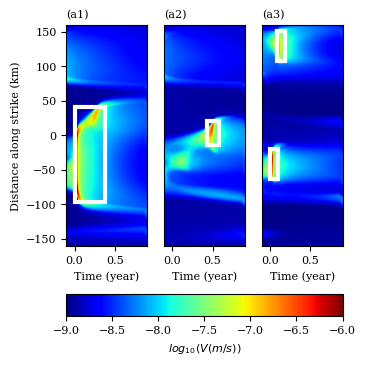

In [ ]:
# making a nice plot for the paper
# I am thinking of of 3 collomn figure with the first coloumn to be the QDYN simulation, the second one with N_m=20 and the third one to be N_m=30. 
# This should be a good idea that you can also see the difference in the forecast as well.

# To make this plot, I think it is better that you have already saved everything in the variables.
V_thresh_min=1e-9
V_thresh_max=1e-6  
x_ox=np.linspace(-L/2,L/2,Nx) 
# 1- define the figure size and the font size
fig = plt.figure(figsize=(3.7, nrows*3.7))
serif_font = fm.FontProperties(family="serif", size=8)
cmap='jet'
    # Use serif font and set font size for all text in the figure
plt.rc('font', family='serif')
plt.rcParams.update({'font.family': 'serif'})
plt.rcParams.update({'font.size': 8})
height_ratios=([1]*nrows)
height_ratios.append(0.1)
gs = gridspec.GridSpec(nrows=nrows+1, ncols=3,width_ratios=[1,1,1],height_ratios=height_ratios) # I put 2 columns for now to wait to see how does the system look like for N_m=30
index_row_plot=0
cax=fig.add_subplot(gs[-1, :])  
shift_string=10
for index in range(len(numbers)):
    time_start_events_PDE=data_prediction_20[index]['TimeStarts_filtered']
    t_0_inversion=data_inversion_20[index]['t_0']
    V_ox_pred_events_20=data_prediction_20[index]["V_ox_pred_events"]
    V_ox_pred_events_30=data_prediction_30[index]["V_ox_pred_events"]
    t_ox_pred_events_20=data_prediction_20[index]["t_ox_pred_events"]
    t_ox_pred_events_30=data_prediction_30[index]["t_ox_pred_events"]
    # run the code to plot things
    for event_counter in range(data_prediction_20[index]['Mags_filtered'].shape[0]): # number of events in the indexth number
        event_name="event #"+str(index_row_plot)
        ax_qdyn= fig.add_subplot(gs[index_row_plot, 0]) # True slip rate
        ax_Nm20= fig.add_subplot(gs[index_row_plot, 1]) # Observed slip rate
        ax_Nm30= fig.add_subplot(gs[index_row_plot, 2]) # Observed slip rate
        string_qdyn='('+letters[index_row_plot]+'1)'
        string_20='('+letters[index_row_plot]+'2)'
        string_30='('+letters[index_row_plot]+'3)'
        # cax1 = fig.add_subplot(gs[index_row_plot, 1])  
        # cax2 = fig.add_subplot(gs[index_row_plot, 3]) 
        # cax3 = fig.add_subplot(gs[index_row_plot, 5])
        # loading data in data_PDE[index]
        V_ox=data_PDE[index]['array1']
        theta_ox=data_PDE[index]['array2']
        t_ox=data_PDE[index]['array3']
        xlimleft=((time_start_events_PDE[event_counter]+t_0_inversion)/cte.t_yr)-tau # time when event happen plus the time of the start of inversion gives the absolute time when an event start in t_ox, note that we use estimation at taw before the absolute time of an event, so if you want to interpolate and compare you need to subtract taw from the abolute time of an event 
        V_ox_interpolated=interpolate(time_interpolation+xlimleft*cte.t_yr,t_ox,V_ox,V_ox.shape[1],V_ox.shape[2])
        # loading time of the start of the events: TimeStarts_filtered, this number should be added to start time which is the time that inversion starts

        TimeStarts_PDE,TimeEnds_PDE,rectangles_PDE,Mags_PDE=Find_T_X_tau_without_p_input(V_ox_interpolated,t_expanded-tau*t_yr,V_thresh,L_thresh,t_yr,x_ox,z_ox,L_fault,mu) # finding the timing and the extent of the PDE. If everything is correct TimeStarts should be very close to zero
        print("Time Starts for PDE is" +str(TimeStarts_PDE/t_yr))
        i=0
        
        
        # Plotting the QDYN acutual slip profile for the events
        V_dip_mean=np.max(V_ox_interpolated,axis=1).T   # Mean Velocity along the dip
        Nt=time_interpolation.shape[0]
        x_ox_t=np.vstack([x_ox]*Nt).T 
        time=np.max(t_expanded,axis=1).T 
        PrettyTime=np.reshape(time.T,-1)
        Prettyx=np.reshape(x_ox_t.T,-1)
        PrettyV=np.reshape(V_dip_mean.T,-1)
        pl=ax_qdyn.scatter(PrettyTime/cte.t_yr-tau,Prettyx*1e-3,marker=".",c=np.log10(PrettyV),cmap=cmap,linewidths=1,vmin=np.log10(V_thresh_min),vmax=np.log10(V_thresh_max))  
        ax_qdyn.set_ylabel(r'Distance along strike (km)',fontproperties=serif_font)
        ax_qdyn=PlotRectangle(ax_qdyn,rectangles_PDE)
        # All_rectangles_PDE = np.append(All_rectangles_PDE, rectangles_PDE[:4].reshape(4, 1), axis=1)
        events_PDE=add_array(events_PDE,event_name, rectangles_PDE)
        #xlimleft=(time_start_events_PDE[event_counter]+t_0_inversion)/cte.t_yr
        #xlimright=(time_start_events_PDE[event_counter]+t_0_inversion)/cte.t_yr+T_final/cte.t_yr
        ax_qdyn.set_xlim(left=-tau,right=-tau+T_final/cte.t_yr)
        # b=fig.colorbar(pl,cax=cax1)
        # b.set_label(label=r'$log_{10}(V(m/s))$',fontproperties=serif_font)
        ax_qdyn.set_ylim(bottom=-L/2/1e3,top=L/2/1e3)
        index_row_plot+=1
        ax_qdyn.text(-tau,L/2/1000+shift_string,string_qdyn)
        # plotting N_m_v=20
        V_ox_pred_events_20_interpolated=interpolate(time_interpolation,t_ox_pred_events_20[event_counter],V_ox_pred_events_20[event_counter],V_ox_pred_events_20[event_counter].shape[1],V_ox_pred_events_20[event_counter].shape[2])
        TimeStarts_20,TimeEnds_20,rectangles_20,Mags_20=Find_T_X_tau_without_p_input(V_ox_pred_events_20_interpolated,t_expanded-tau*t_yr,V_thresh,L_thresh,t_yr,x_ox,z_ox,L_fault,mu)
        print("Time Starts for N_m=20 is" +str(TimeStarts_20/t_yr))
        #PlotRectangle(axes,rectangles)
        V_dip_mean=np.max(V_ox_pred_events_20_interpolated,axis=1).T   # Mean Velocity along the dip
        Nt=time_interpolation.shape[0]
        x_ox_t=np.vstack([x_ox]*Nt).T 
        x_ox_t=np.vstack([x_ox]*Nt).T 
        time=np.max(t_expanded,axis=1).T # what? simply getting rid of the axis 1 because axis 0 and 1 have the same value for time
        
        PrettyTime=np.reshape(time.T,-1)
        Prettyx=np.reshape(x_ox_t.T,-1)
        PrettyV=np.reshape(V_dip_mean.T,-1)
        pl=ax_Nm20.scatter(PrettyTime/cte.t_yr-tau,Prettyx*1e-3,marker=".",c=np.log10(PrettyV),cmap=cmap,linewidths=1,vmin=np.log10(V_thresh_min),vmax=np.log10(V_thresh_max))
        ax_Nm20.set_xlim(left=-tau,right=-tau+(T_final/cte.t_yr))

        # ax_Nm20.set_xlabel(r'Time (year)',fontproperties=serif_font)
        # ax_Nm20.set_ylabel(r'Distance along strike (km)',fontproperties=serif_font)
        # b=fig.colorbar(pl,cax=cax2)
        # b.set_label(label=r'$log_{10}(V(m/s))$',fontproperties=serif_font)
        ax_Nm20.set_ylim(bottom=-L/2/1e3,top=L/2/1e3)
        ax_Nm20.text(-tau,L/2/1000+shift_string,string_20)
        ax_Nm20=PlotRectangle(ax_Nm20,rectangles_20)
        Time_lag20.append((TimeStarts_20[0]-TimeStarts_PDE[0])/t_yr)
        # All_rectangles_20 = np.append(All_rectangles_20, rectangles_20[:4].reshape(4, 1), axis=1)
        
        events_20=add_array(events_20,event_name, rectangles_20)
        
        # plotting N_m_v=30
        V_ox_pred_events_30_interpolated=interpolate(time_interpolation,t_ox_pred_events_30[event_counter],V_ox_pred_events_30[event_counter],V_ox_pred_events_30[event_counter].shape[1],V_ox_pred_events_30[event_counter].shape[2])
        TimeStarts_30,TimeEnds_30,rectangles_30,Mags_30=Find_T_X_tau_without_p_input(V_ox_pred_events_30_interpolated,t_expanded-tau*t_yr,V_thresh,L_thresh,t_yr,x_ox,z_ox,L_fault,mu)
        print("Time Starts for N_m=30 is" +str(TimeStarts_30/t_yr)) 
        V_dip_mean=np.max(V_ox_pred_events_30_interpolated,axis=1).T   # Mean Velocity along the dip
        Nt=time_interpolation.shape[0]
        x_ox_t=np.vstack([x_ox]*Nt).T
        time=np.max(t_expanded,axis=1).T 
        PrettyTime=np.reshape(time.T,-1)
        Prettyx=np.reshape(x_ox_t.T,-1)
        PrettyV=np.reshape(V_dip_mean.T,-1)
        pl=ax_Nm30.scatter(PrettyTime/cte.t_yr-tau,Prettyx*1e-3,marker=".",c=np.log10(PrettyV),cmap=cmap,linewidths=1,vmin=np.log10(V_thresh_min),vmax=np.log10(V_thresh_max))
        ax_Nm30.set_xlim(left=-tau,right=-tau+(T_final/cte.t_yr))
        # ax_Nm30.set_xlabel(r'Time (year)',fontproperties=serif_font)
        # ax_Nm30.set_ylabel(r'Distance along strike (km)',fontproperties=serif_font)
        # b=fig.colorbar(pl,cax=cax3)
        # b.set_label(label=r'$log_{10}(V(m/s))$',fontproperties=serif_font)
        ax_Nm30.set_ylim(bottom=-L/2/1e3,top=L/2/1e3)
        ax_Nm30.text(-tau,L/2/1000+shift_string,string_30)
        ax_Nm30=PlotRectangle(ax_Nm30,rectangles_30)
        Time_lag30.append((TimeStarts_30[0]-TimeStarts_PDE[0])/t_yr)
        # All_rectangles_30 = np.append(All_rectangles_30, rectangles_30[:4].reshape(4, 1), axis=1)

        events_30=add_array(events_30,event_name, rectangles_30)

        # removing y ticks and y numbers 
        #ax_qdyn.set_yticks([])
        ax_Nm20.set_yticks([])
        ax_Nm30.set_yticks([])
        
    
    # putting the xlable outside both of the loops to only print the lable for the last row
ax_qdyn.set_xlabel(r'Time (year)',fontproperties=serif_font)
ax_Nm20.set_xlabel(r'Time (year)',fontproperties=serif_font)
ax_Nm30.set_xlabel(r'Time (year)',fontproperties=serif_font)
b=fig.colorbar(pl,cax=cax,orientation='horizontal')
b.set_label(label=r'$log_{10}(V(m/s))$',fontproperties=serif_font)

# All_rectangles_PDE=All_rectangles_PDE[:,1:]
# All_rectangles_20=All_rectangles_20[:,1:]
# All_rectangles_30=All_rectangles_30[:,1:]

plt.tight_layout()
plt.savefig('/central/groups/astuart/hkaveh/Figs/ROM/prediction_performace.png',dpi=300,bbox_inches='tight')
plt.show()



In [ ]:
# writing a function to find the rupture extent, given the rectangles for the PDE and the rectangles from the prediction

In [ ]:
def find_rup_extent(x_ox,Recs_Pred):
    # This function is written to find the rupture extent of prediction. It works when you have more than one event in your prediction.
    N_events_pred=len(Recs_Pred)
    # make a false like array as in x_ox
    x_ruptured_pred=np.full(x_ox.shape, False, dtype=bool)
    for index in range(N_events_pred):
        x_ruptured_inedx=((x_ox/1e3>= Recs_Pred[index][1]) & (x_ox/1e3<= Recs_Pred[index][1] + Recs_Pred[index][3]))
        x_ruptured_pred=x_ruptured_inedx | x_ruptured_pred # This or here, aggregates the rupture extent of all the events
    return x_ruptured_pred

In [ ]:
True_pos_ratio_20=[]
True_pos_ratio_30=[]
False_pos_ratio_20=[]
False_pos_ratio_30=[]

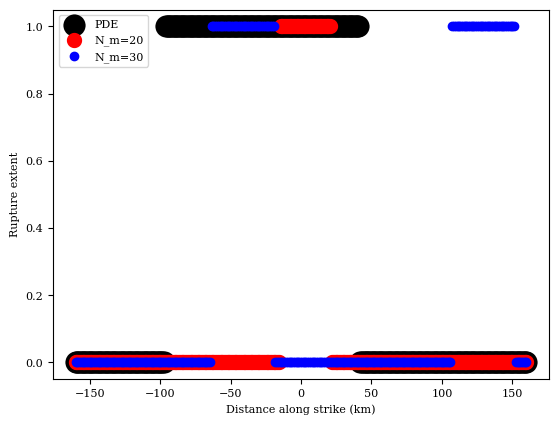

In [ ]:
for index in range(len(events_30)):
    event_name='event #'+str(index)
    x_ruptured_PDE=find_rup_extent(x_ox,events_PDE[event_name])
    x_ruptured_20=find_rup_extent(x_ox,events_20[event_name])
    x_ruptured_30=find_rup_extent(x_ox,events_30[event_name])
    
    plt.figure()
    plt.scatter(x_ox/1e3,x_ruptured_PDE,color='black',label='PDE',linewidth=10)
    plt.scatter(x_ox/1e3,x_ruptured_20,color='red',label='N_m=20',linewidth=5)
    plt.scatter(x_ox/1e3,x_ruptured_30,color='blue',label='N_m=30',linewidth=1)
    plt.legend()
    plt.xlabel('Distance along strike (km)')
    plt.ylabel('Rupture extent')
    
    
    
    
    
    True_pos_ratio_20.append(np.sum(x_ruptured_PDE & x_ruptured_20)/np.sum(x_ruptured_PDE))   # x_ruptured_PDE & x_ruptured_20 gives me the intersection of the two arrays
    True_pos_ratio_30.append(np.sum(x_ruptured_PDE & x_ruptured_30)/np.sum(x_ruptured_PDE))    # same as previous but for N_m=30
    False_pos_ratio_20.append(np.sum(x_ruptured_20 & ~x_ruptured_PDE)/np.sum(~x_ruptured_PDE)) # x_ruptured_20 & ~x_ruptured_PDE gives the extent that we have predicted to rupture but has not ruptured in the PDE
    False_pos_ratio_30.append(np.sum(x_ruptured_30 & ~x_ruptured_PDE)/np.sum(~x_ruptured_PDE)) # same as previous but for N_m=30

In [ ]:
print(True_pos_ratio_20)
print(True_pos_ratio_30)
print(False_pos_ratio_20)
print(False_pos_ratio_30)

[0.2636363636363636]
[0.32727272727272727]
[0.0]
[0.2465753424657534]


In [ ]:
Time_lag30

[0.0036521342159324347]

In [ ]:
True_pos_ratio_20

[0.2636363636363636]

In [ ]:
True_pos_ratio_30

[0.32727272727272727]

In [ ]:
dt=0.05
dp=0.1
bins_t = np.arange(-tau-dt/2, T_final/cte.t_yr+dt/2, dt) 
bins_prob=np.arange(0,1.0001,0.1)


In [ ]:
bins_t

array([-0.125, -0.075, -0.025,  0.025,  0.075,  0.125,  0.175,  0.225,
        0.275,  0.325,  0.375,  0.425,  0.475,  0.525,  0.575,  0.625,
        0.675,  0.725,  0.775,  0.825,  0.875,  0.925,  0.975])

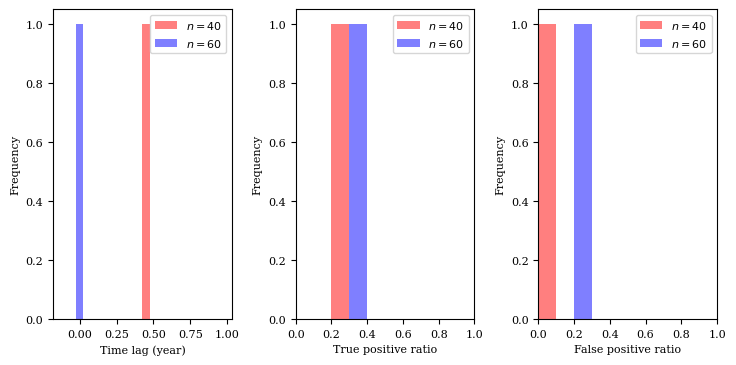

In [ ]:
# Plotting a figure with three subplots, first subplot shows the distribution of Time_starts, second subplot shows the distribution of True_pos_ratio and the third subplot shows the distribution of False_pos_ratio
fig, axs = plt.subplots(1, 3, figsize=(7.4, 3.7))
# find the index in which Time_lag20 is nan

axs[0].hist(Time_lag20, bins=bins_t, color='red',alpha=0.5)
axs[0].hist(Time_lag30, bins=bins_t, color='blue',alpha=0.5)
axs[1].hist(True_pos_ratio_20, bins=bins_prob, color='red',alpha=0.5)
axs[1].hist(True_pos_ratio_30, bins=bins_prob, color='blue',alpha=0.5)
axs[2].hist(False_pos_ratio_20, bins=bins_prob, color='red',alpha=0.5)
axs[2].hist(False_pos_ratio_30, bins=bins_prob, color='blue',alpha=0.5)
axs[0].legend([r'$n=40$', r'$n=60$'])
axs[1].legend([r'$n=40$', r'$n=60$'])
axs[2].legend([r'$n=40$', r'$n=60$'])
axs[0].set_xlabel('Time lag (year)')
axs[0].set_ylabel('Frequency')
axs[1].set_xlabel('True positive ratio')
axs[1].set_ylabel('Frequency')
axs[2].set_xlabel('False positive ratio')
axs[2].set_ylabel('Frequency')
axs[1].set_xlim(0,1)
axs[2].set_xlim(0,1)
plt.tight_layout()
# save the figure
plt.savefig('/central/groups/astuart/hkaveh/Figs/ROM/Performance_metrics.png',dpi=300,bbox_inches='tight')

In [ ]:
bins_prob

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

In [ ]:
False_pos_ratio_30

[0.2465753424657534]

In [ ]:
print(True_pos_ratio_20, True_pos_ratio_30, False_pos_ratio_20, False_pos_ratio_30)

[0.2636363636363636] [0.32727272727272727] [0.0] [0.2465753424657534]


In [ ]:
Time_lag20

[0.42889751198356546]

In [ ]:
Time_lag30

[0.0036521342159324347]

In [ ]:
len(True_pos_ratio_20)

1

In [ ]:
len(False_pos_ratio_20)

1

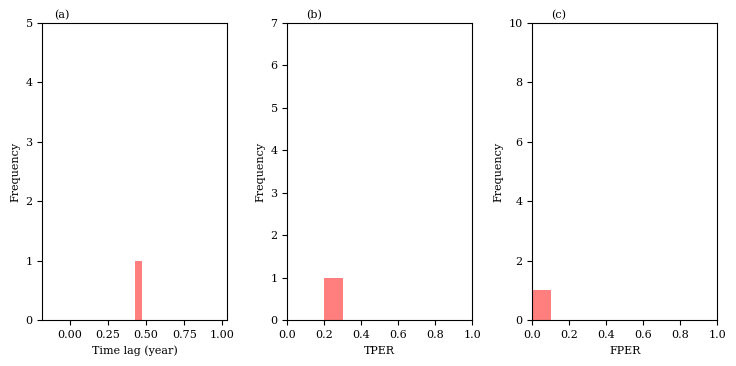

In [ ]:
# Plotting a figure with three subplots, first subplot shows the distribution of Time_starts, second subplot shows the distribution of True_pos_ratio and the third subplot shows the distribution of False_pos_ratio
fig, axs = plt.subplots(1, 3, figsize=(7.4, 3.7))
# if Time_lag20 is greater than t_pred-tau put nan in Time_lag20
print(Time_lag20)
Time_lag20=[Time_lag20[i] if Time_lag20[i]<(t_pred-tau) else np.nan for i in range(len(Time_lag20))]
print(Time_lag20)

index_nan=[i for i in range(len(Time_lag20)) if np.isnan(Time_lag20[i])]


# removing the nan values from True_pos_ratio_20 and False_pos_ratio_20 signal
True_pos_ratio_20=[True_pos_ratio_20[i] for i in range(len(True_pos_ratio_20)) if i not in index_nan]
False_pos_ratio_20=[False_pos_ratio_20[i] for i in range(len(False_pos_ratio_20)) if i not in index_nan]

axs[0].hist(Time_lag20, bins=bins_t, color='red',alpha=0.5)
# axs[0].hist(Time_lag30, bins=bins_t, color='blue',alpha=0.5)
axs[1].hist(True_pos_ratio_20, bins=bins_prob, color='red',alpha=0.5)
# axs[1].hist(True_pos_ratio_30, bins=bins_prob, color='blue',alpha=0.5)
axs[2].hist(False_pos_ratio_20, bins=bins_prob, color='red',alpha=0.5)
# axs[2].hist(False_pos_ratio_30, bins=bins_prob, color='blue',alpha=0.5)
# axs[0].legend([r'$n=40$', r'$n=60$'])
# axs[1].legend([r'$n=40$', r'$n=60$'])
# axs[2].legend([r'$n=40$', r'$n=60$'])
axs[0].set_xlabel('Time lag (year)')
axs[0].set_ylabel('Frequency')
axs[1].set_xlabel('TPER')
axs[1].set_ylabel('Frequency')
axs[2].set_xlabel('FPER')
axs[2].set_ylabel('Frequency')
axs[1].set_xlim(0,1)
axs[2].set_xlim(0,1)
axs[0].set_ylim(top=5)
axs[1].set_ylim(top=7)
axs[2].set_ylim(top=10)
axs[0].set_xlim(right=t_pred-tau)
axs[0].text(-0.15,5.07,'(a)')
axs[1].text(0.1,7.1,'(b)')
axs[2].text(0.1,10.15,'(c)')
plt.tight_layout()
# save the figure
plt.savefig('/central/groups/astuart/hkaveh/Figs/ROM/Performance_metrics_only20.png',dpi=300,bbox_inches='tight')

In [ ]:
len(True_pos_ratio_20)

1

In [ ]:
len(False_pos_ratio_20)

1